In [1]:
!pip uninstall sagemaker -y && pip install sagemaker
sagemaker.__version__

Found existing installation: sagemaker 2.3.0
Uninstalling sagemaker-2.3.0:
  Successfully uninstalled sagemaker-2.3.0
Processing /home/ec2-user/.cache/pip/wheels/ab/83/60/e6932c9fd595e8b62bb5c394f411fd13329158762f9bb9988f/sagemaker-2.3.0-py2.py3-none-any.whl
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [14]:
%%time 
import pickle, gzip, urllib.request, json
import numpy as np

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(train_set[0].shape)

(50000, 784)
CPU times: user 955 ms, sys: 201 ms, total: 1.16 s
Wall time: 7.71 s


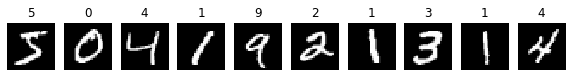

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))

for i in range(0, 10):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    ax = axes[i]
    imgplot = ax.imshow(img_reshape, cmap='gray')
    ax.axis("off")
    ax.set_title(label)

plt.show()

In [16]:
%%time

import os
import boto3
import re
import copy
import time
import io
import struct
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

bucket='sagemaker-200816' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data

s3_client = boto3.client("s3")
    
def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for data_partition_name, data_partition in data_partitions:
        
        print(f"{data_partition_name}: {data_partition[0].shape} {data_partition[1].shape}")
        
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]

        if data_partition_name != 'test':
            # examples: [[y_label, labels...], ...]
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
            
        np.savetxt('data.csv', examples, delimiter=',')
            
        key = f"{prefix}/{data_partition_name}/examples"
        url = f"s3://{prefix}/{data_partition_name}"
        
        s3_client.upload_file(Filename="data.csv", Bucket=bucket, Key=key)

        print(f"Done writing to {url}")

convert_data()

train: (50000, 784) (50000,)
Done writing to s3://sagemaker/xgboost-mnist/train
validation: (10000, 784) (10000,)
Done writing to s3://sagemaker/xgboost-mnist/validation
test: (10000, 784) (10000,)
Done writing to s3://sagemaker/xgboost-mnist/test
CPU times: user 52.2 s, sys: 7.9 s, total: 1min
Wall time: 56.2 s


In [17]:
import sagemaker
from sagemaker import image_uris

container = image_uris.retrieve('xgboost', region=region, version="latest")

In [18]:
train_data_url = f"s3://{bucket}/{prefix}/train"
validation_data_url = f"s3://{bucket}/{prefix}/validation"
s3_output_location = f"s3://{bucket}/{prefix}/xgboost_model_sdk"

print(train_data_url)

s3://sagemaker-200816/sagemaker/xgboost-mnist/train


In [19]:
xgb_model = sagemaker.estimator.Estimator(container,
                                      role, 
                                      instance_count=1, 
                                      instance_type='ml.m4.xlarge',
                                      volume_size = 5,
                                      output_path=s3_output_location,
                                      sagemaker_session=sagemaker.Session())  

In [20]:
xgb_model.set_hyperparameters(max_depth = 5,
                          eta = .2,
                          gamma = 4,
                          min_child_weight = 6,
                          silent = 0,
                          objective = "multi:softmax",
                          num_class = 10,
                          num_round = 10)

In [22]:
train_channel = sagemaker.inputs.TrainingInput(train_data_url, content_type='text/csv')
valid_channel = sagemaker.inputs.TrainingInput(validation_data_url, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [23]:
xgb_model.fit(inputs=data_channels, logs=True)


2020-08-16 01:03:52 Starting - Starting the training job...
2020-08-16 01:03:54 Starting - Launching requested ML instances......
2020-08-16 01:04:59 Starting - Preparing the instances for training...
2020-08-16 01:05:51 Downloading - Downloading input data......
2020-08-16 01:06:47 Training - Training image download completed. Training in progress..Arguments: train
[2020-08-16:01:06:48:INFO] Running standalone xgboost training.
[2020-08-16:01:06:48:INFO] File size need to be processed in the node: 1122.95mb. Available memory size in the node: 8469.05mb
[2020-08-16:01:06:48:INFO] Determined delimiter of CSV input is ','
[01:06:48] S3DistributionType set as FullyReplicated
[01:06:54] 50000x784 matrix with 39200000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-08-16:01:06:54:INFO] Determined delimiter of CSV input is ','
[01:06:54] S3DistributionType set as FullyReplicated
[01:06:55] 10000x784 matrix with 7840000 entries loaded from /opt/ml/inpu